In [2]:
# Working with quaternions
import symforce

symforce.set_symbolic_api("sympy")
symforce.set_log_level("warning")

from symforce.notebook_util import display
import symforce.symbolic as sf
sf.init_printing() 

sa, xa, ya, za = sf.symbols('s_a x_a y_a z_a')
sb, xb, yb, zb = sf.symbols('s_b x_b y_b z_b')
qa = sf.Quaternion(xyz=sf.Vector3(xa, ya, za),
                   w=sa)
qb = sf.Quaternion(xyz=sf.Vector3(xb, yb, zb),
                   w=sb)

In [3]:
# Muliplication
# I'm using quaternion type here and having to use the weird __mul__ 
# function. Later I realized you can just use Rot3 which uses *
qc = qa.__mul__(qb)
qc.w

In [4]:
qc.xyz

⎡sₐ⋅x_b + s_b⋅xₐ + yₐ⋅z_b - y_b⋅zₐ⎤
⎢                                 ⎥
⎢sₐ⋅y_b + s_b⋅yₐ - xₐ⋅z_b + x_b⋅zₐ⎥
⎢                                 ⎥
⎣sₐ⋅z_b + s_b⋅zₐ + xₐ⋅y_b - x_b⋅yₐ⎦

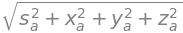

In [5]:
# Length
sf.sqrt(qa.squared_norm())

In [6]:
# Conjugate
qa.conj()
display(qa.conj().__mul__(qa).w)
# Note that is the square of the length!

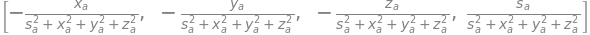

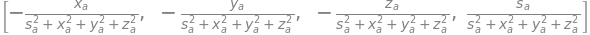

In [7]:
# inverse
display(qa.inverse().to_storage())
display(qa.conj().__div__(qa.squared_norm()).to_storage())

# This should be one: 
display((qa.__mul__(qa.inverse())).simplify().to_storage())

In [8]:
# Simple scalar multiplication ... how the heck is it this hard? 
sf.Quaternion(xyz=sf.Vector3(0,0,0), w=3).__mul__(qa).to_storage()

In [9]:
# Rotating by quaternion is just like with rotation matrix
# The book goes into detail about how to do it by hand but it's not 
# worth the effort lol. It has to do with making the imaginary part 
# of a new quaternion be the xyz of the vector. 
r = sf.Rot3.from_yaw_pitch_roll(0.0, 0.0, 3.14159/4.0)
R = r.to_rotation_matrix()
p = sf.Vector3([1.0,1.0,1.0])
ppR = R*p
ppR

⎡        1.0        ⎤
⎢                   ⎥
⎢9.38185668708513e-7⎥
⎢                   ⎥
⎣ 1.41421356237278  ⎦

In [10]:
r*p

⎡        1.0        ⎤
⎢                   ⎥
⎢9.38185668708513e-7⎥
⎢                   ⎥
⎣ 1.41421356237278  ⎦

In [11]:
# ehh maybe it is worth it to see how to deal with symforce. 
rp = r.inverse()
# Good lord, apparently you can't use a list to build quat. 
P = sf.Rot3(sf.Quaternion(sf.Vector3(1.0,1.0,1.0), 0.0))
# The imaginary part here should be same as r*P above
r*P*rp

<Rot3 <Q xyzw=[1.00000000000000, 9.38185668708513e-7, 1.41421356237278, 0]>>

In [12]:
# 2.4.3 - convert quaternion to rotation matrix. 
display(r, R)
v = r.q.xyz
s = r.q.w
v.skew_symmetric(v)

v*v.transpose() + sf.Matrix33.eye()*s**2 + 2*s*v.skew_symmetric(v)+\
    v.skew_symmetric(v)*v.skew_symmetric(v)

<Rot3 <Q xyzw=[0.382683125915406, 0, 0, 0.923879659446842]>>

⎡1          0                  0         ⎤
⎢                                        ⎥
⎢0  0.707107250279226  -0.707106312093558⎥
⎢                                        ⎥
⎣0  0.707106312093558  0.707107250279226 ⎦

⎡1.0          0                  0         ⎤
⎢                                          ⎥
⎢ 0   0.707107250279226  -0.707106312093558⎥
⎢                                          ⎥
⎣ 0   0.707106312093558  0.707107250279226 ⎦

In [53]:
# now see if we can get axis angle from quat
ang = .785
r = sf.Rot3.from_angle_axis(ang, sf.Vector3(1,1,1))
s = r.q.w
theta = 2*sf.acos(s)
display(f"theta = {theta}")
v = r.q.xyz
v.transpose()/sf.sin(theta/2)


'theta = 0.785000000000000'

[1.0  1.0  1.0]

In [19]:
# Show that rotation matrix is orthogonal
r = sf.Rot3.symbolic('r')
R = r.to_rotation_matrix()
# Orthogonal means transpose is equal to inverse
R.transpose() == r.inverse().to_rotation_matrix()

True

In [51]:
# Prove the Rodrigues formula: 
# R = cos θI + (1 − cos θ) nnT + sin θn∧
theta = sf.Symbol('theta')
axis = sf.Vector3.symbolic('axis')
r = sf.Rot3.from_angle_axis(theta, axis)
Rgt = r.to_rotation_matrix()
R = sf.cos(theta)*sf.I33() + (1 - sf.cos(theta)) * axis *\
axis.transpose() + sf.sin(theta) * axis.skew_symmetric(axis)
test = R-Rgt
test.subs([(theta, .5), (axis[0], 1), (axis[1], 0), (axis[2], 0)])

⎡0  0  0⎤
⎢       ⎥
⎢0  0  0⎥
⎢       ⎥
⎣0  0  0⎦

In [64]:
# assign an upper 3x3 block of a large matrix
m = sf.M55.symbolic('m')
a = sf.M33.symbolic('a')
m[:3, :3] = a
m

⎡a₀ ₀  a₀ ₁  a₀ ₂  m₀ ₃  m₀ ₄⎤
⎢                            ⎥
⎢a₁ ₀  a₁ ₁  a₁ ₂  m₁ ₃  m₁ ₄⎥
⎢                            ⎥
⎢a₂ ₀  a₂ ₁  a₂ ₂  m₂ ₃  m₂ ₄⎥
⎢                            ⎥
⎢m₃ ₀  m₃ ₁  m₃ ₂  m₃ ₃  m₃ ₄⎥
⎢                            ⎥
⎣m₄ ₀  m₄ ₁  m₄ ₂  m₄ ₃  m₄ ₄⎦

In [74]:
# Solve an Ax=b problem
A = sf.Rot3.from_angle_axis(.5, sf.Vector3(1,0,0)).to_rotation_matrix()
b = sf.Vector3(3,4,5)
x = A.inv()*b
A*x

⎡ 3 ⎤
⎢   ⎥
⎢4.0⎥
⎢   ⎥
⎣5.0⎦